# Single Objective Optimization with Credit Risk Analysis 

In [1]:
%%capture
#Cell magic to hide outputs 

#Install dependencies
from io import StringIO
import os
import time
import sys
import IPython
from time import gmtime, strftime

import boto3
import numpy as np
import pandas as pd
import urllib

import sagemaker
from sagemaker.s3 import S3Uploader
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost import XGBoost
from sagemaker.s3 import S3Downloader
from sagemaker.s3 import S3Uploader
from sagemaker import Session
from sagemaker import get_execution_role
from sagemaker.xgboost import XGBoostModel
from sagemaker.sklearn import SKLearnModel
from sagemaker.pipeline import PipelineModel
from sagemaker.inputs import TrainingInput


session = Session()
bucket = session.default_bucket()
prefix = "sagemaker/sagemaker-amt-credit-risk-model"
region = session.boto_region_name

# Define IAM role
role = get_execution_role()

## Train XGBoost Model
In this step, we will train an XGBoost model on the preprocessed data. We will use our own training script with the built-in XGBoost container provided by SageMaker.

Alternatively, for your own use case, you can also bring your own model (trained elsewhere) to SageMaker for processing with SageMaker Clarify


### Set up XGBoost Estimator

Next, let us set up:    
 1. Pre-defined values for Hyperparameters for XGBoost algorithm
 1. XGBoost Estimator for SageMaker

    

In [2]:
hyperparameters = {
    "max_depth": "5",
    "eta": "0.1",
    "gamma": "4",
    "min_child_weight": "6",
    "silent": "1",
    "objective": "binary:logistic",
    "num_round": "100",
    "subsample": "0.8",
    "eval_metric": "auc",
    "early_stopping_rounds": "20",
    "output_data_dir": "/opt/ml/output/data/",
}

entry_point = "train_xg_amt_single.py"
source_dir = "training/"
output_path = "s3://{0}/{1}/{2}".format(bucket, prefix, "xgb_model")
code_location = "s3://{0}/{1}/code".format(bucket, prefix)

estimator = XGBoost(
    entry_point=entry_point,
    source_dir=source_dir,
    output_path=output_path,
    code_location=code_location,
    hyperparameters=hyperparameters,
    instance_type="ml.c5.xlarge",
    instance_count=1,
    framework_version="0.90-2",
    py_version="py3",
    role=role,
)

### SageMaker AMT (HPO)

Now it's time to run the HPO job to train and find the best model 

#### NOTE: THIS CELL WILL RUN FOR APPROX. 5-8 MINUTES! PLEASE BE PATIENT.

In [3]:
#Retrieve variables stored in first notebook 
%store -r train_data_path
%store -r val_data_path
%store -r model_path

In [4]:
# Automatic Model Tuning (HPO)
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'eta': ContinuousParameter(1e-3, 1, 'Logarithmic'),
                        'min_child_weight': ContinuousParameter(1e-6, 10, 'Logarithmic'),
                        'gamma': ContinuousParameter(1e-6, 10, 'Logarithmic'),
                        'max_depth': IntegerParameter(2, 10, 'Linear')}

objective_metric_name = 'validation:auc'

tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=100, # 100
                            max_parallel_jobs=10, #16
                           )

tuning_job_name = "xgb-tuner-{}".format(strftime("%d-%H-%M-%S", gmtime()))

inputs = {'train': train_data_path, 'validation': val_data_path}

tuner.fit(inputs, job_name=tuning_job_name)

tuner.wait()

tuner_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...................................................................................!
!


### The best Area Under Curve (AUC) score, alongside the Disparate Impact was found by going into the SageMaker logs where they are saved. You can find the logs by following the image guide below

In the SageMaker console page navigate the left menu and find Training -> Hyperparameter Tuning Jobs. That will bring up all the recent Tuuning jobs and you can click the latest one. 
![Step1](images/Step1A.jpg)

Scrolling down the tuning job page will bring you to “Best training job summary”. Here you can see the name of the best training job and the optimized value of the metric specified. In this case you can see that the AUC value is optimized at 0.91. Click on the best training job name.
![Step2](images/Step2A.jpg)

Scrolling down the page of the best training job, you will find a section under “Monitor” called “View logs”. Click on this to take you to CloudWatch logs.
![Step3](images/Step3A.jpg)

Scrolling down this current page you will encounter a section called “Log streams”. Click the name of your training job under this section.
![Step4](images/Step4A.jpg)

On this current page we can scroll all the way down and view all of the values the AI model has tried, the final values are at the bottom and are the optimized ones. 
![Step5](images/Step5A.jpg)

### As can be seen we have a very high AUC Score which is due to the optimization of the tuning job. The tuning was not optimized for DI therefor the value is not the best (lowest) as can be. Please refer back to these values as you will require them to complete the lab in the next notebook.  



In [5]:
#Best AUC Score for single Metric Optimization 
auc_score = 0.74
#Acompanying Disparate Impact
dppl = 0.75

Lets now create a model endpoint to make predictions based on the best training job we have obtained

In [6]:
#Get Processed Validation Dataset
n = val_data_path+"val_features.csv"
test_dataset = S3Downloader.read_file(n)
n

's3://sagemaker-us-east-2-921553072635/sagemaker/sagemaker-amt-credit-risk-model/data/preprocessed/val/val_features.csv'

In [7]:
print(len(test_dataset))
test_dataset = test_dataset.split("\n")
print(len(test_dataset))

44154
221


In [8]:
for i in range(len(test_dataset)-1):
    test_dataset[i] = np.fromstring(test_dataset[i], dtype=float, sep=',')

In [9]:
count0 = 0
count1 = 0
for i in range(len(test_dataset)-1):
    if test_dataset[i][40] == 0:
        count0=count0+1
    if test_dataset[i][40] == 1:
        count1=count1+1
print(count0)
print(count1)

0
0


In [10]:
#TESTING ABOVE
tuner.best_training_job()

'xgb-tuner-26-17-19-04-033-b11b1c0f'

In [11]:
xgboost_model_data = (
    "s3://{}/{}/{}/{}".format(bucket, prefix, "xgb_model", tuner.best_training_job()) + "/output/model.tar.gz"
)

In [12]:
#TESTING
xgboost_inference_code_location = "s3://{}/{}/{}/code".format(bucket, prefix, "xgb_model")

xgboost_model = XGBoostModel(
    name="xgb-model-{0}".format(str(int(time.time()))),
    model_data=xgboost_model_data,
    entry_point="inference.py",
    source_dir="inference/xgboost/",
    code_location=xgboost_inference_code_location,
    framework_version="0.90-2",
    py_version="py3",
    role=role,
    sagemaker_session=session,
)

In [13]:
from datetime import datetime

endpoint_name = f"SINGLE-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("EndpointName =", endpoint_name)

EndpointName = SINGLE-2023-01-26-1726


In [14]:
#Create Endpoint Instance

#Instance Count
initial_instance_count=1 # Example
#instance Type
instance_type='ml.m5.large' # Example

FinalModel = xgboost_model.deploy(
    initial_instance_count=initial_instance_count,
    instance_type=instance_type,
    endpoint_name=endpoint_name
)

-----!

In [15]:
#Set up predictor 
from sagemaker.serializers import CSVSerializer
predictor = sagemaker.predictor.Predictor(
    endpoint_name,
    session,
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)

In [16]:
#Make Predictions on the test dataset
Single_Optimized_Predictions = []
for i in range(len(test_dataset)-1):
    Single_Optimized_Predictions.append(predictor.predict(test_dataset[i]))

In [17]:
#See first 3 predictions and how they look. We have the double brackets meaning each element is a 3 dimensional element, we will make them a single dimension in the next cell 
print(Single_Optimized_Predictions[0])
print(Single_Optimized_Predictions[1])
print(Single_Optimized_Predictions[2])

[['0.7337338']]
[['0.94518006']]
[['0.9456592']]


In [18]:
#Turn each item into a single dimension element in the list  
Predictions = []
for i in range(len(Single_Optimized_Predictions)):
    Predictions.append(Single_Optimized_Predictions[i][0][0])

In [19]:
#Look at first 3 processed predictions. They are now i nthe format we want
print(Predictions[0])
print(Predictions[1])
print(Predictions[2])

0.7337338
0.94518006
0.9456592


In [20]:
#Each prediction value is between 0 - 1. But the target variable "Credit Risk" is either bad (0) or good (1) there for we will round up/down to ensure every value is either 0 or 1
for i in range(len(Predictions)):
    if (float(Predictions[i]) >= float(0.5)):
        Predictions[i] = 1 
    elif (float(Predictions[i]) < float(0.5)):
        Predictions[i] = 0

In [21]:
#Look at first 3 predictions now to confirm we will be able to see they are either 0 or 1 
print(Predictions[0])
print(Predictions[1])
print(Predictions[2])

1
1
1


In [22]:
#Check how many predictions were 0 (Bad Credit) and 1(Good Credit)
print(Predictions.count(0))
print(Predictions.count(1))

68
152


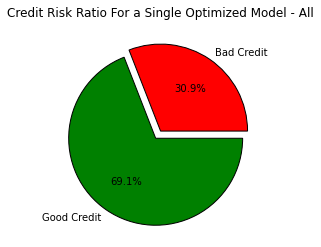

In [23]:
#Graph the predictions as a pie graph
from matplotlib import pyplot as plt

slices = [Predictions.count(0),Predictions.count(1)]
labels = ['Bad Credit', 'Good Credit']
colors = ['red', 'green']
explode = [0, 0.1]
plt.pie(slices, labels=labels, autopct='%1.1f%%', explode=explode, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title("Credit Risk Ratio For a Single Optimized Model - All")
plt.show()

In [24]:
test_dataset[0][-1]

2.0

In [25]:
#Now let us take a look at Foreign worker predictions only. the last element in the list represents Foreign workers (1 means foreign 2 means non-foreign)
filtered_dataset=[]
for i in range(len(test_dataset)-1):
    if test_dataset[i][-1] == 1:
        filtered_dataset.append(test_dataset[i])
len(filtered_dataset)

36

In [26]:
#Make Predictions on the filtered test dataset with only Foreign Workers
Single_F_Predictions = []
for i in range(len(filtered_dataset)):
    Single_F_Predictions.append(predictor.predict(filtered_dataset[i]))

In [27]:
#Turn each item into a single dimension element in the list  
for i in range(len(Single_F_Predictions)):
    Single_F_Predictions[i]=(Single_F_Predictions[i][0][0])

In [28]:
Single_F_Predictions

['0.2862774',
 '0.06912269',
 '0.29497668',
 '0.075319745',
 '0.24426395',
 '0.036359027',
 '0.02628616',
 '0.12667994',
 '0.030781768',
 '0.02682332',
 '0.2110773',
 '0.19238576',
 '0.22990663',
 '0.081512764',
 '0.3376731',
 '0.028388042',
 '0.061994657',
 '0.8415497',
 '0.37680793',
 '0.019338168',
 '0.48963562',
 '0.1564905',
 '0.015742503',
 '0.14973402',
 '0.118518226',
 '0.21958497',
 '0.053401366',
 '0.0205502',
 '0.7068394',
 '0.07206859',
 '0.06789858',
 '0.82920635',
 '0.72153616',
 '0.13628021',
 '0.011861026',
 '0.03210104']

In [29]:
#Each prediction value is between 0 - 1. But the target variable "Credit Risk" is either bad (0) or good (1) there for we will round up/down to ensure every value is either 0 or 1
for i in range(len(Single_F_Predictions)):
    if (float(Single_F_Predictions[i]) >= float(0.5)):
        Single_F_Predictions[i] = 1 
    elif (float(Single_F_Predictions[i]) < float(0.5)):
        Single_F_Predictions[i] = 0

In [30]:
#Check how many predictions were 0 (Bad Credit) and 1(Good Credit)
print(Single_F_Predictions.count(0))
print(Single_F_Predictions.count(1))

32
4


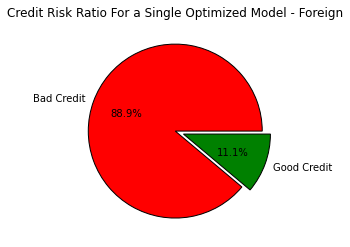

In [31]:
#Pie Graph
slices = [Single_F_Predictions.count(0),Single_F_Predictions.count(1)]
labels = ['Bad Credit', 'Good Credit']
colors = ['red', 'green']
explode = [0, 0.1]
plt.pie(slices, labels=labels, autopct='%1.1f%%', explode=explode, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title("Credit Risk Ratio For a Single Optimized Model - Foreign")
plt.show()

In [32]:
#Read labels of validation set
m = val_data_path+"val_labels.csv"
test_labels = S3Downloader.read_file(m)
m

's3://sagemaker-us-east-2-921553072635/sagemaker/sagemaker-amt-credit-risk-model/data/preprocessed/val/val_labels.csv'

In [33]:
test_labels = test_labels.split("\n")

In [34]:
#See length of test_labels
print(len(test_labels))
#Take out last element in test labels since it is an empty quote
test_labels.pop()

221


''

In [35]:
#See ratio of labels
print(test_labels.count('0'))
print(test_labels.count('1'))

100
120


36
148


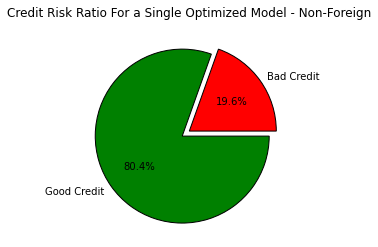

In [36]:
#TESTING - Non Foreign Workers
filtered_dataset=[]
for i in range(len(test_dataset)-1):
    if test_dataset[i][-1] == 2:
        filtered_dataset.append(test_dataset[i])
len(filtered_dataset)

Single_F_Predictions = []
for i in range(len(filtered_dataset)):
    Single_F_Predictions.append(predictor.predict(filtered_dataset[i]))
    
for i in range(len(Single_F_Predictions)):
    Single_F_Predictions[i]=(Single_F_Predictions[i][0][0])
    
for i in range(len(Single_F_Predictions)):
    if (float(Single_F_Predictions[i]) >= float(0.5)):
        Single_F_Predictions[i] = 1 
    elif (float(Single_F_Predictions[i]) < float(0.5)):
        Single_F_Predictions[i] = 0

print(Single_F_Predictions.count(0))
print(Single_F_Predictions.count(1))

#Pie Graph
slices = [Single_F_Predictions.count(0),Single_F_Predictions.count(1)]
labels = ['Bad Credit', 'Good Credit']
colors = ['red', 'green']
explode = [0, 0.1]
plt.pie(slices, labels=labels, autopct='%1.1f%%', explode=explode, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title("Credit Risk Ratio For a Single Optimized Model - Non-Foreign")
plt.show()

In [37]:
#CLEAN UP - Uncomment code in this cell to Spin Down Endpoint

# Create a low-level SageMaker service client.
#sagemaker_client = boto3.client('sagemaker', region_name="us-east-2")

# Delete endpoint
#sagemaker_client.delete_endpoint(EndpointName=endpoint_name)

### You may now move onto "3-Multi-Objective-AMT.ipynb" to explore Multi Objective Optimization tuning jobs to optimize both AUC & DI